# CIRES Earth Lab Code Submission

The code in this notebook was put together with the intent of showing some of my knowledge with respect to machine learning. In it, I train a Variational Autoencoder (VAE) on images of forests and mountains. I then take the encoder and attach a dense classifier to the top, giving me the ability to classify the images based on the latent space representation learned by the VAE.

We begin by importing libraries:

In [1]:
import numpy as np
import pandas as pd

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle

from scipy import stats

from tensorflow.keras import Model, Input, layers, regularizers, optimizers, losses, metrics

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

from vaeHelpers import Sampling, kl_divergence, reconstruction_loss

C:\Users\crist\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Looks like I need to check my pandas install. 

Next, we'll make sure that the GPU is available:

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


Great. 

The data I am using was taken from kaggle (https://www.kaggle.com/nitishabharathi/scene-classification). There are 6 classes of scenes to choose from. I am going to pick forests and mountains for this code submission. These classes correspond to the labels 1 and 2. Let's take a peek at the metadata csv that came with this data:

In [3]:
samples_df = pd.read_csv("scenes\\train.csv")
class_names = ['Forests','Mountains']
samples_df.head(10)

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4
5,8.jpg,1
6,9.jpg,5
7,10.jpg,2
8,12.jpg,5
9,13.jpg,2


Okay, so 8.jpg should be an image of a forest scene:

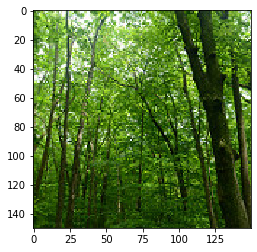

In [4]:
img = Image.open("scenes\\train\\8.jpg")
plt.imshow(img)
plt.show()

Checks out. Next we'll grab all metadata for images of forest or mountain scenes:

In [5]:
samples_df.label = samples_df.label.astype("str")
samples_df = samples_df[(samples_df.label == '1') | (samples_df.label == '2')].sample(frac=1)

Now we'll set up a z-test for the training data. I ran a few experiments and determined that using the pixel mean for the z-test provides a good outcome for training the VAE, because the distributions of the means for each class are clearly centered at different values. Plots of the mean and standard deviation distributions for these two classes are in the plots folder of this repo.

In [6]:
img_means = []

for i in range(len(samples_df)):
    img = Image.open("scenes\\train\\" + samples_df.image_name.iloc[i])
    img = np.array(img)
    img_means.append(img.mean())
samples_df['Pixel Mean'] = np.array(img_means)

We're going to throw out all images which have means that are greater than 1 standard deviation out from the norm of their respective distribution. This is done to force clustering in the latent space learned by the VAE.

In [7]:
forests_df = samples_df[samples_df.label=='1']
mountains_df = samples_df[samples_df.label=='2']

forests_df = forests_df[np.abs(stats.zscore(forests_df['Pixel Mean'])) < 1]
mountains_df = mountains_df[np.abs(stats.zscore(mountains_df['Pixel Mean'])) < 1]

print('forest images: {}'.format(forests_df.shape[0]))
print('mountain images: {}'.format(mountains_df.shape[0]))

forest images: 1869
mountain images: 2075


The number of images in each class is a bit unbalanced. Given more time I would have used class weights to address this. It turns out that the z-test is good enough on its own. Now we'll put the curated images back into a DataFrame and shuffle the rows:

In [8]:
select_df = shuffle(pd.concat([forests_df, mountains_df]),random_state=1)

It's time to set up the train/val/test split, which is 80-10-10:

In [9]:
training_percentage = 0.8
training_item_count = int(len(select_df)*training_percentage)
validation_item_count = len(select_df)-int(len(select_df)*training_percentage)
training_df = select_df[:training_item_count]
val_test_df = select_df[training_item_count:].sample(frac=1)
test_item_count = int(len(val_test_df)*(.5))
validation_df = val_test_df[:test_item_count]
test_df = val_test_df[:test_item_count]

Now we'll take the train/val/test DataFrames and create data generators. Although we are dealing with a small dataset that can be held in memory, generators are handy for those instances where that's not the case.

In [10]:
batch_size = 32
image_size = 100
channels = 3
target_size = (image_size, image_size, )

train_datagen = ImageDataGenerator(rescale=1. / 255)
e_train_gen = train_datagen.flow_from_dataframe(
    dataframe = training_df,
    x_col='image_name',
    y_col='label',
    directory='scenes\\train\\',
    target_size=target_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='input')

validation_datagen = ImageDataGenerator(rescale=1. / 255)
e_val_gen = validation_datagen.flow_from_dataframe(
    dataframe = validation_df,
    x_col='image_name',
    y_col='label',
    directory='scenes\\train\\',
    target_size=target_size,
    shuffle=False,
    batch_size=batch_size,
    class_mode='input')

test_datagen = ImageDataGenerator(rescale=1. / 255)
e_test_gen = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col='image_name',
    y_col='label',
    directory='scenes\\train\\',
    target_size=target_size,
    shuffle=False,
    batch_size=batch_size,
    class_mode='categorical')

Found 3155 validated image filenames.
Found 394 validated image filenames.
Found 394 validated image filenames belonging to 2 classes.


I want to take a sample from the test generator to use for demonstrating the VAE's utility. I grab some images and their labels for visualization later. 

In [11]:
imgs = []
truth = []
for i in range(12): #12 batches of size 32 -> 384 images   
    examples = e_test_gen.next()
    images = imgs.append(examples[0])
    truth.append(examples[1])

img_array = np.vstack([imgs[0],imgs[1]])
truth_array = np.vstack([truth[0],truth[1]])

for i in range(len(imgs)-2):
    img_array = np.vstack([img_array,imgs[i+2]])
    truth_array = np.vstack([truth_array,truth[i+2]])

labels = [np.where(r==1)[0][0] for r in truth_array]

classes = []
for i in range(len(labels)):
    classes.append(class_names[labels[i]])

The following code block builds the encoder and the decoder, then puts them into the VAE model. This is a bare-bones shallow VAE implementation with no tuning done.

In [12]:
#begin VAE code
latent_dim = 2

#**********ENCODER**********#
E_input = Input(shape=(image_size,image_size,channels))

x = layers.Conv2D(32, 3, strides=2,
                         activation='relu',padding='same',
                         kernel_initializer='orthogonal',
                         kernel_regularizer=regularizers.l2(2e-3))(E_input)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, strides=2,
                         activation='relu',padding='same',
                         kernel_initializer='orthogonal',
                         kernel_regularizer=regularizers.l2(2e-3))(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, 3, strides=2,
                         activation='relu',padding='same',
                         kernel_initializer='orthogonal',
                         kernel_regularizer=regularizers.l2(2e-3))(x)
x = layers.MaxPooling2D()(x)

x = layers.Flatten()(x)

z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

z = Sampling()(z_mean, z_log_var)

encoder = Model(E_input, [z_mean, z_log_var, z])

#KL Divergence
encoder.add_loss(kl_divergence(z_mean, z_log_var))

#**********DECODER**********#
D_input = Input(shape=(latent_dim,))

y = layers.Dense(5 * 5 * 8, activation='relu')(D_input)
y = layers.Dense(25 * 25 * 64, activation='relu')(y)

y = layers.Reshape((25, 25, 64))(y)

y = layers.Conv2DTranspose(32, 3, strides=2,
                                  activation='relu', padding='same',
                                  kernel_initializer='orthogonal',
                                  kernel_regularizer=regularizers.l2(2e-3))(y)
D_output = layers.Conv2DTranspose(3, 3, strides=2,
                                 activation='relu', padding='same',
                                 kernel_initializer='orthogonal',
                                 kernel_regularizer=regularizers.l2(2e-3))(y)

decoder = Model(D_input, D_output)

z_mean, z_log_var, z = encoder(E_input)
decoder_output = decoder(z)

vae = Model(E_input, decoder_output)

In [13]:
vae.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
model (Functional)           [(None, 2), (None, 2), (N 93764     
_________________________________________________________________
model_1 (Functional)         (None, 100, 100, 3)       8059931   
Total params: 8,153,695
Trainable params: 8,153,695
Non-trainable params: 0
_________________________________________________________________


Once the VAE is built, we must compile it. We can then sample the encoder after compilation to get a baseline for its performance.

In [14]:
vae.compile(optimizer=optimizers.Adam(), 
            loss=reconstruction_loss,
            metrics=['mse'])

In [15]:
#sample encoder before training
pretrain_encodings = encoder(img_array)[2].numpy()

Training step:

In [16]:
history = vae.fit(e_train_gen,
                  validation_data=e_val_gen,
                  epochs=20)

Epoch 1/20
99/99 [==============================] - 3s 24ms/step - loss: 10247.6289 - mse: 0.1156 - val_loss: 6628.0493 - val_mse: 0.0624
Epoch 2/20
99/99 [==============================] - 2s 21ms/step - loss: 6620.0376 - mse: 0.0595 - val_loss: 6478.5684 - val_mse: 0.0567
Epoch 3/20
99/99 [==============================] - 2s 22ms/step - loss: 6587.2959 - mse: 0.0586 - val_loss: 6444.7261 - val_mse: 0.0557
Epoch 4/20
99/99 [==============================] - 2s 21ms/step - loss: 6499.6860 - mse: 0.0554 - val_loss: 6406.2437 - val_mse: 0.0545
Epoch 5/20
99/99 [==============================] - 2s 21ms/step - loss: 6477.8008 - mse: 0.0546 - val_loss: 6405.4932 - val_mse: 0.0544
Epoch 6/20
99/99 [==============================] - 2s 21ms/step - loss: 6435.0918 - mse: 0.0527 - val_loss: 6300.0317 - val_mse: 0.0497
Epoch 7/20
99/99 [==============================] - 2s 21ms/step - loss: 6345.1948 - mse: 0.0485 - val_loss: 6255.1885 - val_mse: 0.0476
Epoch 8/20
99/99 [======================

We're ready to see how the VAE did. We'll sample the trained encoder and plot the points in latent space.

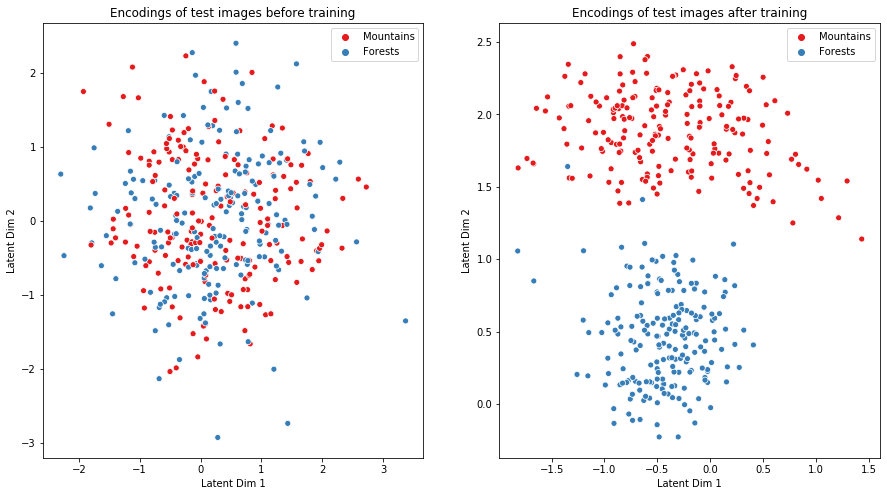

In [25]:
posttrain_encodings = encoder(img_array)[2].numpy()

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
sns.scatterplot(pretrain_encodings[:, 0],
                pretrain_encodings[:, 1],
                hue=classes, ax=axs[0],
                palette=sns.color_palette("Set1", 2));
sns.scatterplot(posttrain_encodings[:, 0],
                posttrain_encodings[:, 1],
                hue=classes, ax=axs[1],
                palette=sns.color_palette("Set1", 2));

axs[0].set_title('Encodings of test images before training');
axs[1].set_title('Encodings of test images after training');

for ax in axs: 
    ax.set_xlabel('Latent Dim 1')
    ax.set_ylabel('Latent Dim 2')
    ax.legend(loc='upper right')
    
f.savefig('plots\\vae_before_after.jpg')

Success! The classes are separated into distinct clusters in the latent space. 

Next we'll set up more data generators to feed into a classifier. Note that we are using all of the available images for these generators.

In [18]:
training_percentage = 0.8
training_item_count = int(len(samples_df)*training_percentage)
validation_item_count = len(samples_df)-int(len(samples_df)*training_percentage)
training_df = samples_df[:training_item_count]
val_test_df = samples_df[training_item_count:].sample(frac=1)
test_item_count = int(len(val_test_df)*(.5))
validation_df = val_test_df[:test_item_count]
test_df = val_test_df[:test_item_count]

In [19]:
train_datagen = ImageDataGenerator(rescale=1. / 255)
c_train_gen = train_datagen.flow_from_dataframe(
    dataframe = training_df,
    x_col='image_name',
    y_col='label',
    directory='scenes\\train\\',
    target_size=target_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1. / 255)
c_val_gen = validation_datagen.flow_from_dataframe(
    dataframe = validation_df,
    x_col='image_name',
    y_col='label',
    directory='scenes\\train\\',
    target_size=target_size,
    shuffle=False,
    batch_size=batch_size,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
c_test_gen = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col='image_name',
    y_col='label',
    directory='scenes\\train\\',
    target_size=target_size,
    shuffle=False,
    batch_size=batch_size,
    class_mode='categorical')

Found 4561 validated image filenames belonging to 2 classes.
Found 570 validated image filenames belonging to 2 classes.
Found 570 validated image filenames belonging to 2 classes.


Now that the encoder has been trained and it does what we want, we'll freeze its weights before we connect it to a dense classifier.

In [20]:
encoder.trainable = False

z_mean, z_log_var, z = encoder(E_input,training=False)

z = layers.Dense(64,activation='relu')(z)
z = layers.Dense(16,activation='relu')(z)
z = layers.Dropout(.25)(z)
out = layers.Dense(2,activation='sigmoid')(z)

classifier = Model(E_input,out)

In [21]:
classifier.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
model (Functional)           [(None, 2), (None, 2), (N 93764     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 34        
Total params: 95,030
Trainable params: 1,266
Non-trainable params: 93,764
___________________________________________________

All that's left is to compile the classifier and train it:

In [22]:
classifier.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=[metrics.BinaryAccuracy()])

In [23]:
classifier_history = classifier.fit(c_train_gen, epochs=10, validation_data=c_val_gen)

Epoch 1/10
143/143 [==============================] - 3s 20ms/step - loss: 8.6447 - binary_accuracy: 0.7179 - val_loss: 8.4522 - val_binary_accuracy: 0.8807
Epoch 2/10
143/143 [==============================] - 3s 19ms/step - loss: 8.4112 - binary_accuracy: 0.8931 - val_loss: 8.2872 - val_binary_accuracy: 0.9289
Epoch 3/10
143/143 [==============================] - 3s 19ms/step - loss: 8.3678 - binary_accuracy: 0.9053 - val_loss: 8.2762 - val_binary_accuracy: 0.9421
Epoch 4/10
143/143 [==============================] - 3s 19ms/step - loss: 8.3603 - binary_accuracy: 0.9065 - val_loss: 8.2670 - val_binary_accuracy: 0.9430
Epoch 5/10
143/143 [==============================] - 3s 19ms/step - loss: 8.3598 - binary_accuracy: 0.9078 - val_loss: 8.2685 - val_binary_accuracy: 0.9404
Epoch 6/10
143/143 [==============================] - 3s 19ms/step - loss: 8.3540 - binary_accuracy: 0.9092 - val_loss: 8.2669 - val_binary_accuracy: 0.9404
Epoch 7/10
143/143 [==============================] - 3s 1

Now let's run the test data through the classifier:

In [24]:
classifier.evaluate(c_test_gen)

18/18 [==============================] - 0s 16ms/step - loss: 8.2635 - binary_accuracy: 0.9447


[8.263509750366211, 0.9447368383407593]

Not bad. Re-runs of this notebook show that the classifier hovers around the 90% accuracy mark.

- There are a few things I would have done if I had more time:
    - I'd like to investigate using other pixel statistics for the z-test, such as median and variance.
    - class weights could be used to address the class imbalance in this dataset.
    - k-fold validation is warranted in this situation due to the small size of the training set.
    - it would be interesting to feed the latent space representations of the training data through a random forest classifier and compare performance.
    - the latent space representation should be compared to a simpler dimensionality reduction method, such as PCA.
    - more metrics should be taken such as precision, recall, and ROC AUC to give a better picture of the model's performance.